In [1]:
import os
import cv2
import glob
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

class CoreDataset(Dataset):
    def __init__(self, transform=None):
        self.path_masks = glob.glob('data/abdominal_US/RUS/annotations/test/*.png')
        self.path_images = [p.replace("annotations", "images").replace("png", "jpg") for p in self.path_masks]
    
        self.transform = transform
        
    def __len__(self):
        return len(self.path_images)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.path_images[idx], cv2.IMREAD_COLOR)
        mask = cv2.imread(self.path_masks[idx], cv2.IMREAD_COLOR)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        image = cv2.resize(image, (512, 512))
        mask = cv2.resize(mask, (512, 512))
        
        sample = {'image': image, 'mask': mask}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
# add image normalization transform at some point
   
class ToTensor(object):
    def __call__(self, sample):
        
        image, mask = sample['image'], sample['mask']  
        # standard scaling would be probably better then dividing by 255 (subtract mean and divide by std of the dataset)
        image = np.array(image) / 255
        # convert colors to "flat" labels
        
        mask = rgb2mask(np.array(mask))
        sample = {
            'image': torch.from_numpy(image).permute(2,0,1).float(),
            'mask': torch.from_numpy(mask).long()
        }
        
        return sample
    
    
batch_size = 1
val_dataset = CoreDataset(transform=transforms.Compose([ToTensor()]))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [2]:
LABEL_TO_COLOR = {
    0: [0, 0, 0], # background 
    1: [0, 255, 0], # gallbladder
    2: [255, 255, 0], # kidney
    3: [0, 255, 255], # adrenals
    4: [100, 0, 100], # liver
    5: [0, 0, 255], # pancreas
    6: [255, 0, 0], # vessels
    7: [255, 0, 255], # spleen
    8: [255, 255, 255], # bones    
}

def mask2rgb(mask):
    rgb = np.zeros(mask.shape+(3,), dtype=np.uint8)
    
    for i in np.unique(mask):
            rgb[mask==i] = LABEL_TO_COLOR[i]
            
    return rgb

def rgb2mask(rgb):
    mask = np.zeros((rgb.shape[0], rgb.shape[1]))

    for k, v in LABEL_TO_COLOR.items():
        mask[np.all(rgb==v, axis=2)] = k
        
    return mask

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x
    

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)

        return x

In [4]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.functional import accuracy
        
class UnetPredictor(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
        
    def forward(self, x):
        return self.model(x)
    
    
    def step(self, batch):
        x, y = batch['image'], batch['mask']
        logits = self(x)
        
        probs = F.softmax(logits, dim=1)
        loss = F.cross_entropy(probs, y)
        preds = torch.argmax(probs, dim=1)
        
        return probs, loss, preds
    
    
    def training_step(self, batch, batch_idx):
        _, loss, preds = self.step(batch)
        
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        _, loss, preds = self.step(batch)
        
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        
    
    def test_step(self, batch, batch_idx):
        _, loss, preds = self.step(batch)
        
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
    
    
    def predict_step(self, batch, batch_idx):
        probs, _, _ = self.step(batch)
        
        return probs

    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    
    def lr_scheduler_step(self, scheduler, optimizer_idx, metric):
        scheduler.step(epoch=self.current_epoch)

        
callbacks = [
    ModelCheckpoint(monitor='valid_loss', save_top_k=5, dirpath='weights/SimpleUNet_finetuning', filename='UNet-{epoch:03d}-{valid_loss:.4f}-{valid_accuracy:.4f}'),
]        
        
model = UNet(n_channels=3, n_classes=len(LABEL_TO_COLOR))
unet_predictor = UnetPredictor(model)

ckpt_fname = "UNet-epoch=092-valid_loss=1.4737-valid_accuracy=0.0000.ckpt"
unet_predictor = unet_predictor.load_from_checkpoint("weights/SimpleUNet/" + ckpt_fname, model=model)
        
trainer = pl.Trainer(max_epochs=100, 
                     gpus=[0], 
                     enable_progress_bar=True, 
                     callbacks=callbacks, 
                     precision=16)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:429: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
trainer.fit(unet_predictor, val_loader, val_loader)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/ubuntu/Workspace/UltrasonographyImageAnalysis/weights/SimpleUNet_finetuning exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 13.4 M
-------------------------------
13.4 M    Trainable params
0         Non-trainable params
13.4 M    Total params
26.792    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:473: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_work

Training: 0it [00:00, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

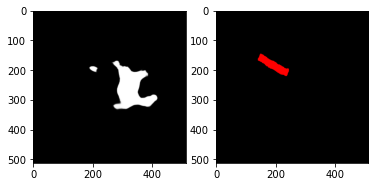

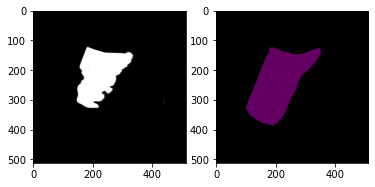

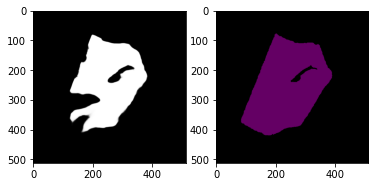

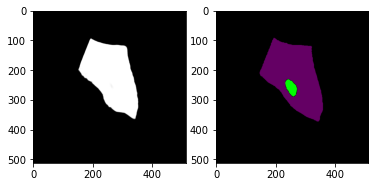

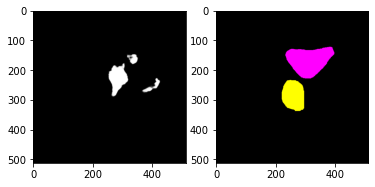

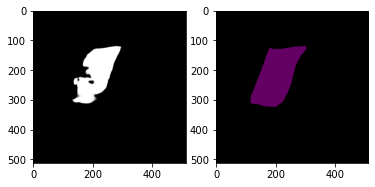

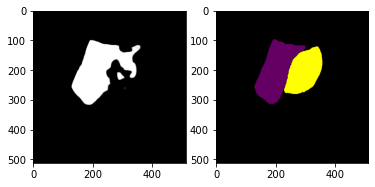

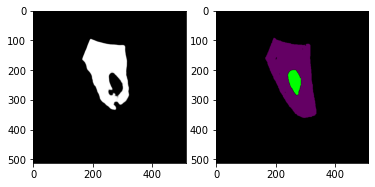

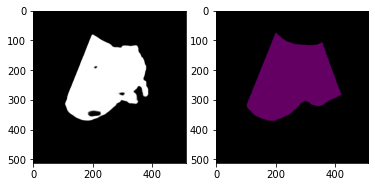

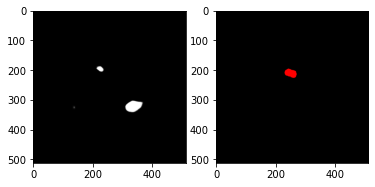

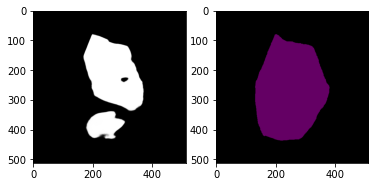

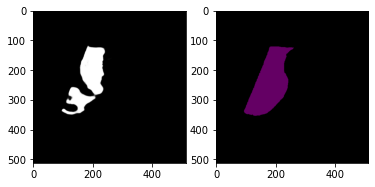

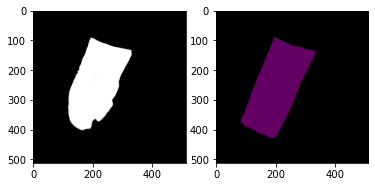

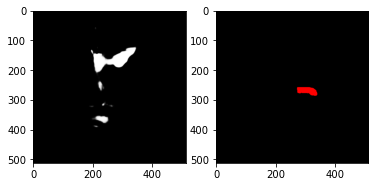

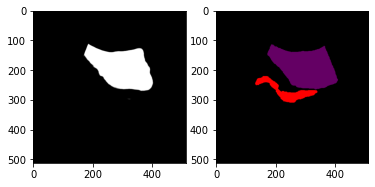

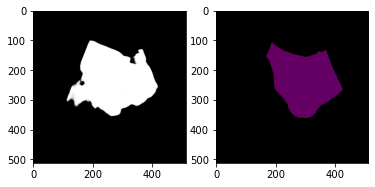

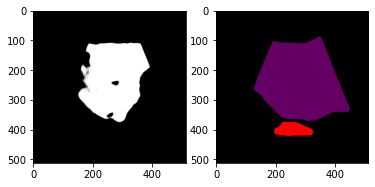

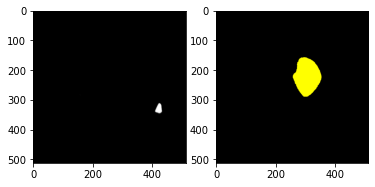

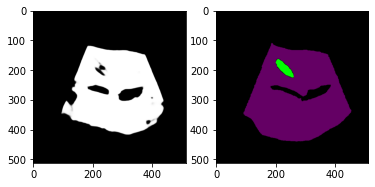

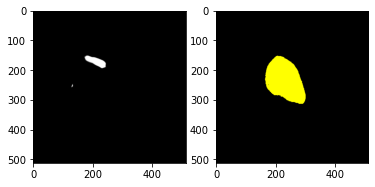

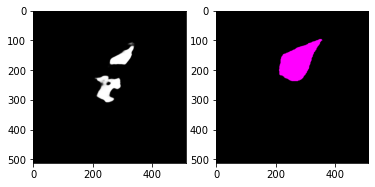

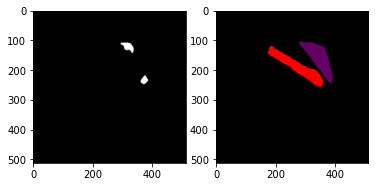

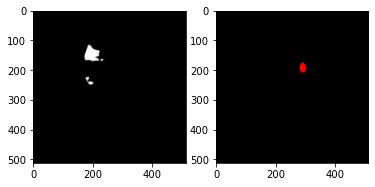

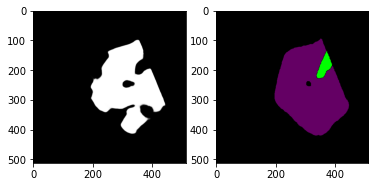

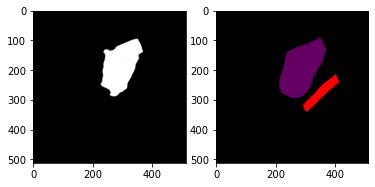

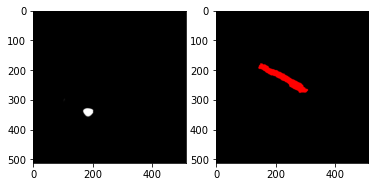

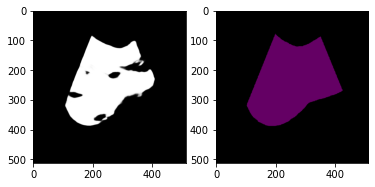

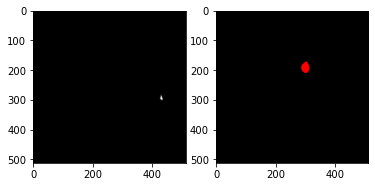

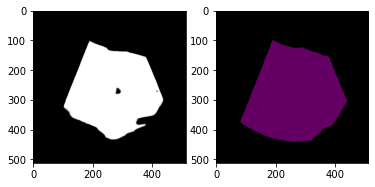

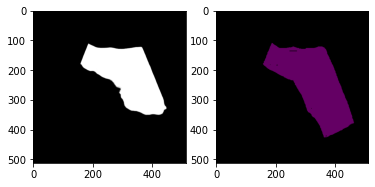

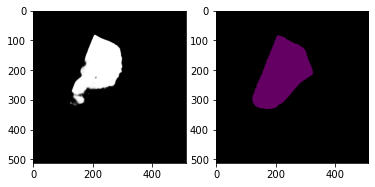

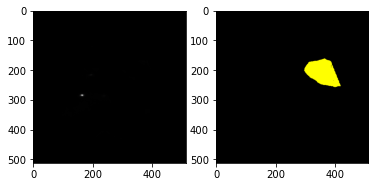

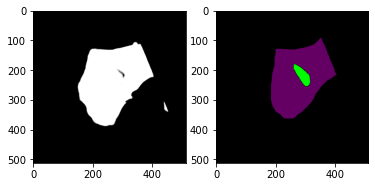

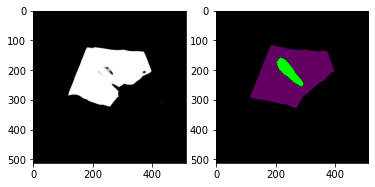

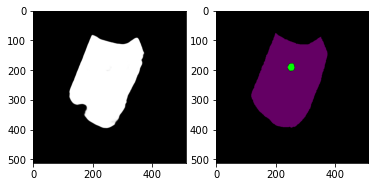

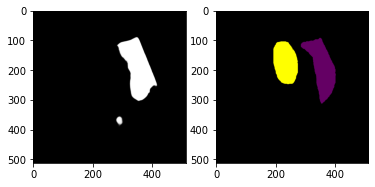

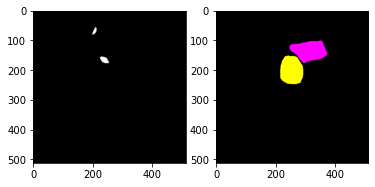

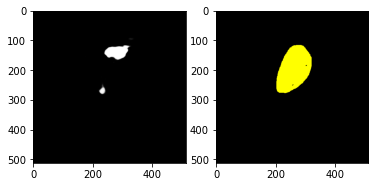

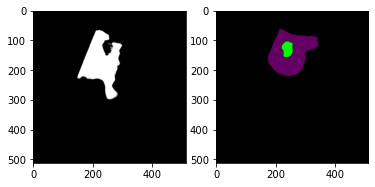

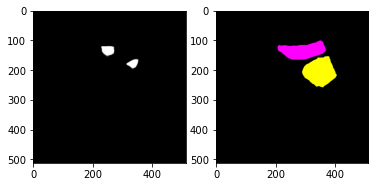

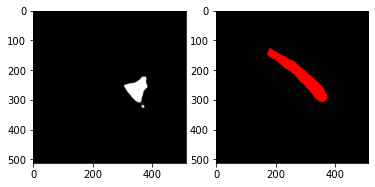

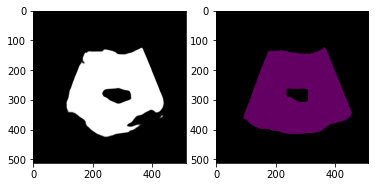

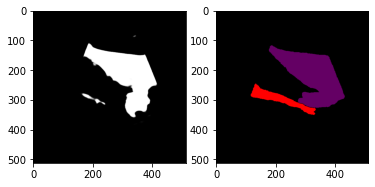

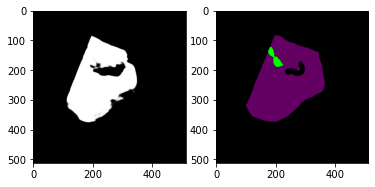

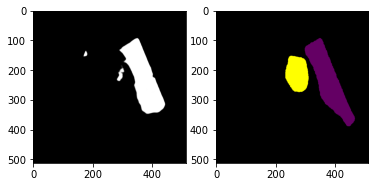

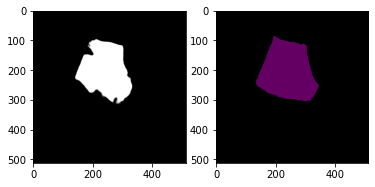

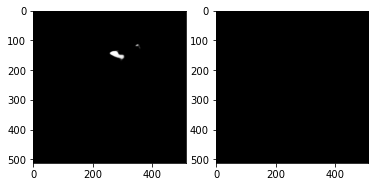

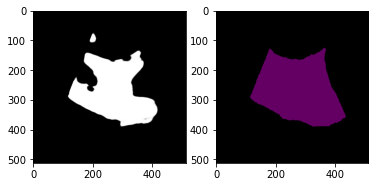

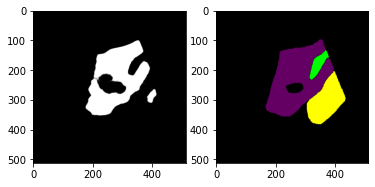

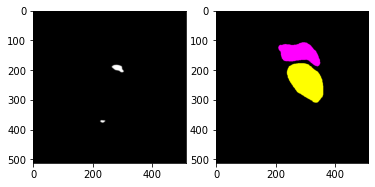

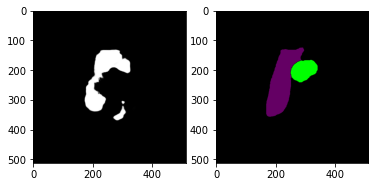

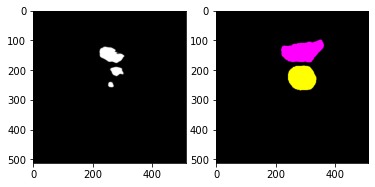

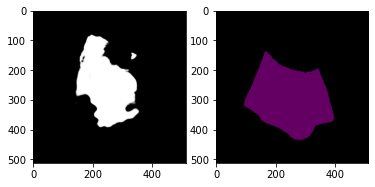

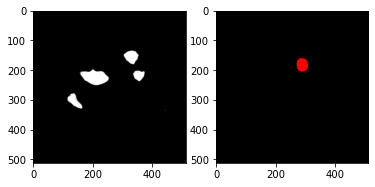

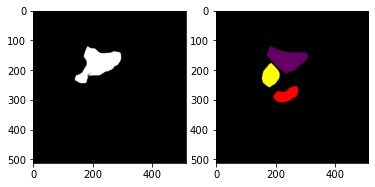

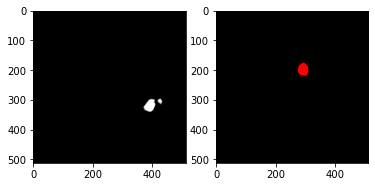

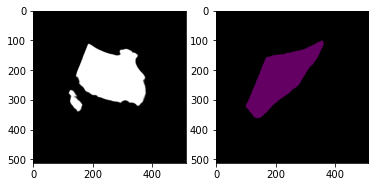

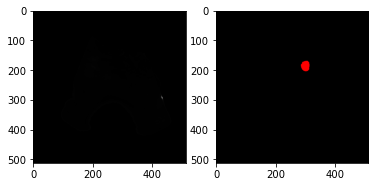

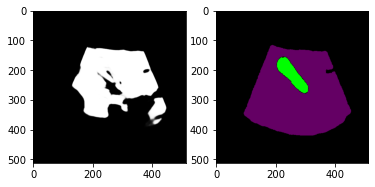

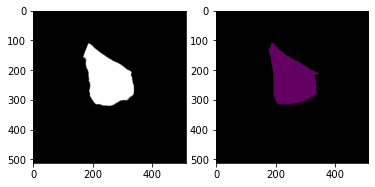

In [7]:
import matplotlib.pyplot as plt

ckpt_fname = "UNet-epoch=088-valid_loss=1.4147-valid_accuracy=0.0000.ckpt"
unet_predictor = unet_predictor.load_from_checkpoint("weights/SimpleUNet_finetuning/" + ckpt_fname, model=model)

unet_predictor.model.eval()

ct = 0
for batch in val_loader:
    preds = unet_predictor.model(batch['image'])
    preds = torch.softmax(preds, dim=1)
    image = preds[0]
    image = image.moveaxis(0, -1)
    
    liver = image[:, :, 4].detach().numpy()
    
    target = batch['mask'][0]
    target = target.detach().numpy()
    
    plt.subplot(1, 2, 1)
    plt.imshow(liver, cmap="gray")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask2rgb(target))
    
    plt.show()
    

In [34]:
batch_size = 1

class CoreDataset(Dataset):
    def __init__(self, transform=None):
        self.path_images = glob.glob('data/test/*.jpg')
    
        self.transform = transform
        
    def __len__(self):
        return len(self.path_images)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.path_images[idx], cv2.IMREAD_COLOR)
#         mask = cv2.imread(self.path_masks[idx], cv2.IMREAD_COLOR)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        image = cv2.resize(image, (512, 512))
#         mask = cv2.resize(mask, (512, 512))
        
        sample = {'image': image}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    
class ToTensor(object):
    def __call__(self, sample):
        image = sample['image']
        image = np.array(image) / 255

        sample = {
            'image': torch.from_numpy(image).permute(2,0,1).float()
        }
        
        return sample    


val_dataset = CoreDataset(transform=transforms.Compose([ToTensor()]))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

0.16778945922851562


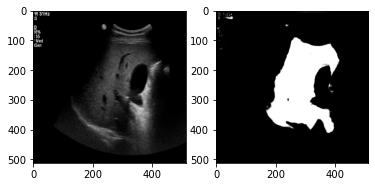

0.22078323364257812


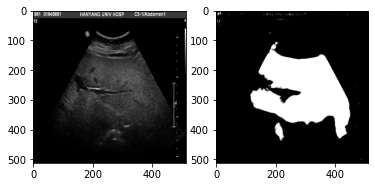

0.2584342956542969


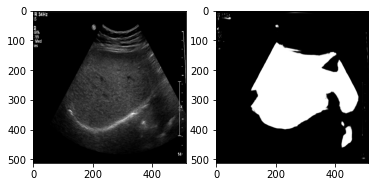

0.09311294555664062


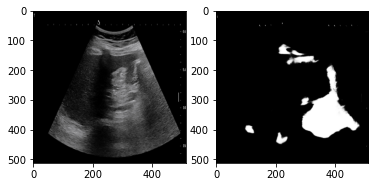

0.24856185913085938


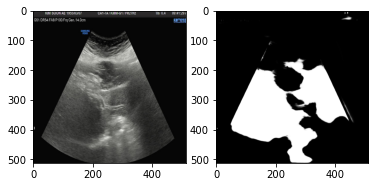

0.15409088134765625


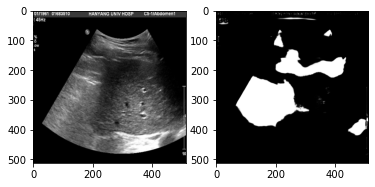

0.19393539428710938


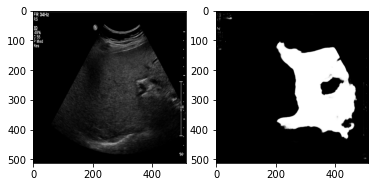

0.07423019409179688


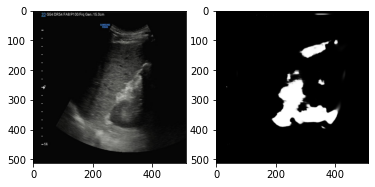

0.3188934326171875


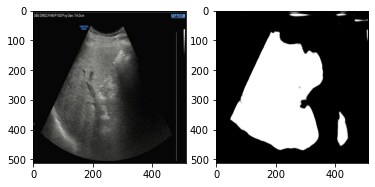

In [35]:
for batch in val_loader:
    preds = unet_predictor.model(batch['image'])
    preds = torch.softmax(preds, dim=1)
    image = preds[0]
    image = image.moveaxis(0, -1)
    
    liver = image[:, :, 4].detach().numpy()
    print(np.sum(liver >= 0.3) / np.size(liver))
    
    plt.subplot(1, 2, 1)
    plt.imshow(batch['image'][0].moveaxis(0, -1), cmap="gray")
    
    plt.subplot(1, 2, 2)
    plt.imshow(liver, cmap="gray")
    
    plt.show()